# CZ1015 Project

Dataset from **World Happiness Report 2018** by *the United Nations Sustainable Development Solutions Network,*
*in partnership with the Ernesto Illy Foundation*  
Source: http://worldhappiness.report/ed/2018/

---
Purpose of Project: To use the available dataset to predict the happiness score in year 2019

By: Beh Wei Feng & Jiang Fangshan & Ng Yi Liang, Randy

## Part 0: Importing Required Python Libraries

In [1]:
#Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

In [2]:
#Plotly Libraries
import plotly.offline as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly import tools

In [3]:
# Activate inline plotting in notebook
py.init_notebook_mode(connected = False)

## Part 1: Simple Visualization of Happiness Score in 2018 Report
---
The happiness scores for all countries in year 2018 is presented on the world map.

>The happiness scores are represented by a color scale, with darker color representing higher score.  
>Grey color is applied to countries without a happiness score in the report.

In [4]:
#An Overview of World Happiness Score
score = pd.read_excel('WHR2018Chapter2OnlineData.xls', sheet_name = 'Figure2.2', usecols = range(0,2)) #import score data
world = pd.read_csv('world.csv') #import abbreviations of countries
score = pd.merge(score, world, on='Country') #merge the two datasets

#plot the choropleth graph for happiness score in 2018 report
trc = dict (type = 'choropleth', locations = score['Code'], colorscale = 'Blues', reversescale=True, z = score['Happiness score'], text = score['Country'])
lyt = go.Layout(
    title = go.layout.Title(
        text = '2018 Happiness Score'
    ),
    geo = go.layout.Geo(
        landcolor = 'grey',
        showland = True,
        showcountries = True,
        showframe = False,
        showcoastlines = False,
        projection = go.layout.geo.Projection(
            type = 'equirectangular'
        )
    )
)
map = go.Figure(data = [trc], layout = lyt)
py.iplot(map)

## Part 2: Deciding on the Machine Learning Models for Variable Value Prediction
---
In this part, we are going to decide on appropriate machine learning models for predicting the values  
of the six variables in the next year to calculate the predicted happiness scores. These variables are:  
>Log GDP per capita  
>Social support  
>Healthy life expectancy at birth	 
>Freedom to make life choices	 
>Generosity	 
>Perceptions of corruption

### Importing the Dataset
The dataset for the six variables is imported into a Pandas data frame  
The variable data2_1 holds the data frame

In [5]:
data2_1 = pd.read_excel('WHR2018Chapter2OnlineData.xls', sheet_name = 'Table2.1', usecols = range(0,9))
data2_1.drop(['Life Ladder'], axis=1, inplace=True)

data2_1.head()

country  year  Log GDP per capita  Social support  \
0  Afghanistan  2008            7.168690        0.450662   
1  Afghanistan  2009            7.333790        0.552308   
2  Afghanistan  2010            7.386629        0.539075   
3  Afghanistan  2011            7.415019        0.521104   
4  Afghanistan  2012            7.517126        0.520637   

   Healthy life expectancy at birth  Freedom to make life choices  Generosity  \
0                         49.209663                      0.718114    0.181819   
1                         49.624432                      0.678896    0.203614   
2                         50.008961                      0.600127    0.137630   
3                         50.367298                      0.495901    0.175329   
4                         50.709263                      0.530935    0.247159   

   Perceptions of corruption  
0                   0.881686  
1                   0.850035  
2                   0.706766  
3                   0.731109  
4                   0.775620

Check the data types of the variables in the data frame

In [6]:
data2_1.dtypes

country                              object
year                                  int64
Log GDP per capita                  float64
Social support                      float64
Healthy life expectancy at birth    float64
Freedom to make life choices        float64
Generosity                          float64
Perceptions of corruption           float64
dtype: object

Check data summary

In [7]:
data2_1.describe()

year  Log GDP per capita  Social support  \
count  1562.000000         1535.000000     1549.000000   
mean   2011.820743            9.220822        0.810669   
std       3.419787            1.184035        0.119370   
min    2005.000000            6.377396        0.290184   
25%    2009.000000            8.310665        0.748304   
50%    2012.000000            9.398610        0.833047   
75%    2015.000000           10.190634        0.904329   
max    2017.000000           11.770276        0.987343   

       Healthy life expectancy at birth  Freedom to make life choices  \
count                       1553.000000                   1533.000000   
mean                          62.249887                      0.728975   
std                            7.960671                      0.145408   
min                           37.766476                      0.257534   
25%                           57.299580                      0.633754   
50%                           63.803192                      0.748014   
75%                           68.098228                      0.843628   
max                           76.536362                      0.985178   

        Generosity  Perceptions of corruption  
count  1482.000000                1472.000000  
mean      0.000079                   0.753622  
std       0.164202                   0.185538  
min      -0.322952                   0.035198  
25%      -0.114313                   0.697359  
50%      -0.022638                   0.808115  
75%       0.094649                   0.880089  
max       0.677773                   0.983276

### Trying Linear Regression
---
For each country, and for each variable, we obtain a linear regression model, such that:  
>Response Variable: **One of the six variables**  
>Predictor Feature: **Year**  
>Regression Model : **Variable** = $a$ $\times$ **Year** + $b$  

After which, we calculate the *Explained Variance* of the model for each country.  
If the *Explained Variance* of a model is higher or equal to 0.5, we determine that this model has a *High Explained Variance*.  
Otherwise, it has a *Low Explained Variance*.  
For country with a model of *High Explained Variance*, the value of the variable will be calculated directly through this model.  
Otherwise, other approaches of prediction will be explored later.  
The linear regression models will be stored in a Pandas data frame, which will be retrieved later.  
Countries with too few data points (≤3) for a specific variable will be deleted, because the prediction will be too inacurate.

In [8]:
# Import LinearRegression model from Scikit-Learn
from sklearn.linear_model import LinearRegression

Obtaining models for Log GDP per capita

In [9]:
#Prediction of Log GDP per capita

#obtain non null data for the country
data2_1_nonull = data2_1[data2_1['Log GDP per capita'].isnull() == False]

evdata_GDP = {}
index = 0
for country_name in data2_1_nonull['country'].unique():
  #obtain data for the country
  country_data = data2_1_nonull[data2_1_nonull["country"].isin([country_name])]
  year = pd.DataFrame(country_data['year'])
  GDP = pd.DataFrame(country_data['Log GDP per capita'])
  #remove country with only three or fewer data points:
  if (len(country_data['Log GDP per capita']) <= 3):
    country_data = data2_1[data2_1["country"].isin([country_name])]
    data2_1.drop([int(i) for i in list(country_data.index.values)], inplace=True)
    continue
  # Create a Linear Regression object
  linreg = LinearRegression()
  # Train the Linear Regression model
  linreg.fit(year, GDP)
  # Explained Variance (R^2)
  ev = linreg.score(year, GDP)
  #Store related values
  evdata_GDP[index] = [country_name, ev, linreg]
  index += 1
evdata_GDP = pd.DataFrame.from_dict(evdata_GDP, orient='index', columns = ['country', 'Explained Variance', 'linreg'])

  
#print out num of large explained variance vs. small explained variance
c_large = 0
c_small = 0
for ev in evdata_GDP['Explained Variance']:
  if ev >= 0.5:
    c_large += 1
  else:
    c_small += 1
print("High\tLow")
print(c_large,"\t",c_small)

#present the explained variance
evdata_GDP[["country","Explained Variance"]].sort_values('Explained Variance', ascending=False).head(n=10)

High	Low
122 	 27


country  Explained Variance
87    Mauritius            0.999787
74         Laos            0.999744
145     Vietnam            0.999262
143  Uzbekistan            0.998390
59    Indonesia            0.998361
10   Bangladesh            0.998347
58        India            0.997028
129  Tajikistan            0.996917
130    Tanzania            0.995262
94      Myanmar            0.995079

Visualize the *Explained Variance* Distribution for Log GDP per capita

In [10]:
#Plot out the distribution of Explained Variance values
trace = go.Histogram(x = evdata_GDP['Explained Variance'], histnorm = 'density', xbins = dict(start = 0, end = 1.0, size = 0.1))
layout = go.Layout(title = 'Explained Variance Distribution', width = 750, height = 400)
data = [trace]
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

Obtaining models for Social support

In [11]:
#Prediction of Social support

#obtain non null data for the country
data2_1_nonull = data2_1[data2_1['Social support'].isnull() == False]

evdata_SS = {}
index = 0
for country_name in data2_1_nonull['country'].unique():
  #obtain data for the country
  country_data = data2_1_nonull[data2_1_nonull["country"].isin([country_name])]
  year = pd.DataFrame(country_data['year'])
  SS = pd.DataFrame(country_data['Social support'])
  #remove country with only three or fewer data points:
  if (len(country_data['Social support']) <= 3):
    country_data = data2_1[data2_1["country"].isin([country_name])]
    data2_1.drop([int(i) for i in list(country_data.index.values)], inplace=True)
    continue
  # Create a Linear Regression object
  linreg = LinearRegression()
  # Train the Linear Regression model
  linreg.fit(year, SS)
  # Explained Variance (R^2)
  ev = linreg.score(year, SS)
  #Store related values
  evdata_SS[index] = [country_name, ev, linreg]
  index += 1
evdata_SS = pd.DataFrame.from_dict(evdata_SS, orient='index', columns = ['country', 'Explained Variance', 'linreg'])

  
#print out num of large explained variance vs. small explained variance
c_large = 0
c_small = 0
for ev in evdata_SS['Explained Variance']:
  if ev >= 0.5:
    c_large += 1
  else:
    c_small += 1
print("High\tLow")
print(c_large,"\t",c_small)

#present the explained variance
evdata_SS[["country","Explained Variance"]].sort_values('Explained Variance', ascending=False).head(n=10)

High	Low
28 	 121


country  Explained Variance
20                    Burundi            0.998382
24   Central African Republic            0.902434
120         Somaliland region            0.889092
71                     Kuwait            0.782923
1                     Albania            0.770423
139      United Arab Emirates            0.755405
144                 Venezuela            0.743891
18                   Bulgaria            0.712215
100              North Cyprus            0.698566
69                      Kenya            0.694540

Visualize the *Explained Variance* Distribution for Social support

In [12]:
#Plot out the distribution of Explained Variance values
trace = go.Histogram(x = evdata_SS['Explained Variance'], histnorm = 'density', xbins = dict(start = 0, end = 1.0, size = 0.1))
layout = go.Layout(title = 'Explained Variance Distribution', width = 750, height = 400)
data = [trace]
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

Obtaining models for Healthy life expectancy at birth

In [13]:
#Prediction of Healthy life expectancy at birth

#obtain non null data for the country
data2_1_nonull = data2_1[data2_1['Healthy life expectancy at birth'].isnull() == False]

evdata_HLE = {}
index = 0
for country_name in data2_1_nonull['country'].unique():
  #obtain data for the country
  country_data = data2_1_nonull[data2_1_nonull["country"].isin([country_name])]
  year = pd.DataFrame(country_data['year'])
  HLE = pd.DataFrame(country_data['Healthy life expectancy at birth'])
  #remove country with only three or fewer data points:
  if (len(country_data['Healthy life expectancy at birth']) <= 3):
    country_data = data2_1[data2_1["country"].isin([country_name])]
    data2_1.drop([int(i) for i in list(country_data.index.values)], inplace=True)
    continue
  # Create a Linear Regression object
  linreg = LinearRegression()
  # Train the Linear Regression model
  linreg.fit(year, HLE)
  # Explained Variance (R^2)
  ev = linreg.score(year, HLE)
  #Store related values
  evdata_HLE[index] = [country_name, ev, linreg]
  index += 1
evdata_HLE = pd.DataFrame.from_dict(evdata_HLE, orient='index', columns = ['country', 'Explained Variance', 'linreg'])

  
#print out num of large explained variance vs. small explained variance
c_large = 0
c_small = 0
for ev in evdata_HLE['Explained Variance']:
  if ev >= 0.5:
    c_large += 1
  else:
    c_small += 1
print("High\tLow")
print(c_large,"\t",c_small)

#present the explained variance
evdata_HLE[["country","Explained Variance"]].sort_values('Explained Variance', ascending=False).head(n=10)

High	Low
147 	 0


country  Explained Variance
102  Palestinian Territories            1.000000
4                  Argentina            0.999995
64               Ivory Coast            0.999993
140                  Uruguay            0.999969
9                    Bahrain            0.999942
39                     Egypt            0.999878
20                   Burundi            0.999832
103                   Panama            0.999710
92                Mozambique            0.999698
80                Madagascar            0.999687

Visualize the *Explained Variance* Distribution for Healthy life expectancy at birth

In [14]:
#Plot out the distribution of Explained Variance values
trace = go.Histogram(x = evdata_HLE['Explained Variance'], histnorm = 'density', xbins = dict(start = 0, end = 1.0, size = 0.1))
layout = go.Layout(title = 'Explained Variance Distribution', width = 750, height = 400)
data = [trace]
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

Obtaining models for Freedom to make life choices

In [15]:
#Prediction of Freedom to make life choices

#obtain non null data for the country
data2_1_nonull = data2_1[data2_1['Freedom to make life choices'].isnull() == False]

evdata_FC = {}
index = 0
for country_name in data2_1_nonull['country'].unique():
  #obtain data for the country
  country_data = data2_1_nonull[data2_1_nonull["country"].isin([country_name])]
  year = pd.DataFrame(country_data['year'])
  FC = pd.DataFrame(country_data['Freedom to make life choices'])
  #remove country with only three or fewer data points:
  if (len(country_data['Freedom to make life choices']) <= 3):
    country_data = data2_1[data2_1["country"].isin([country_name])]
    data2_1.drop([int(i) for i in list(country_data.index.values)], inplace=True)
    continue
  # Create a Linear Regression object
  linreg = LinearRegression()
  # Train the Linear Regression model
  linreg.fit(year, FC)
  # Explained Variance (R^2)
  ev = linreg.score(year, FC)
  #Store related values
  evdata_FC[index] = [country_name, ev, linreg]
  index += 1
evdata_FC = pd.DataFrame.from_dict(evdata_FC, orient='index', columns = ['country', 'Explained Variance', 'linreg'])

  
#print out num of large explained variance vs. small explained variance
c_large = 0
c_small = 0
for ev in evdata_FC['Explained Variance']:
  if ev >= 0.5:
    c_large += 1
  else:
    c_small += 1
print("High\tLow")
print(c_large,"\t",c_small)

#present the explained variance
evdata_FC[["country","Explained Variance"]].sort_values('Explained Variance', ascending=False).head(n=10)

High	Low
49 	 100


country  Explained Variance
65                     Jamaica            0.933268
79                   Macedonia            0.932721
143                 Uzbekistan            0.931542
93                     Myanmar            0.930334
3                       Angola            0.904797
56                     Iceland            0.899614
125                      Sudan            0.893645
142                    Uruguay            0.874586
54   Hong Kong S.A.R. of China            0.848802
50                   Guatemala            0.846073

Visualize the *Explained Variance* Distribution for Freedom to make life choices

In [16]:
#Plot out the distribution of Explained Variance values
trace = go.Histogram(x = evdata_FC['Explained Variance'], histnorm = 'density', xbins = dict(start = 0, end = 1.0, size = 0.1))
layout = go.Layout(title = 'Explained Variance Distribution', width = 750, height = 400)
data = [trace]
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

Obtaining models for Generosity

In [17]:
#Prediction of Generosity

#obtain non null data for the country
data2_1_nonull = data2_1[data2_1['Generosity'].isnull() == False]

evdata_G = {}
index = 0
for country_name in data2_1_nonull['country'].unique():
  #obtain data for the country
  country_data = data2_1_nonull[data2_1_nonull["country"].isin([country_name])]
  year = pd.DataFrame(country_data['year'])
  G = pd.DataFrame(country_data['Generosity'])
  #remove country with only three or fewer data points:
  if (len(country_data['Generosity']) <= 3):
    country_data = data2_1[data2_1["country"].isin([country_name])]
    data2_1.drop([int(i) for i in list(country_data.index.values)], inplace=True)
    continue
  # Create a Linear Regression object
  linreg = LinearRegression()
  # Train the Linear Regression model
  linreg.fit(year, G)
  # Explained Variance (R^2)
  ev = linreg.score(year, G)
  #Store related values
  evdata_G[index] = [country_name, ev, linreg]
  index += 1
evdata_G = pd.DataFrame.from_dict(evdata_G, orient='index', columns = ['country', 'Explained Variance', 'linreg'])

  
#print out num of large explained variance vs. small explained variance
c_large = 0
c_small = 0
for ev in evdata_G['Explained Variance']:
  if ev >= 0.5:
    c_large += 1
  else:
    c_small += 1
print("High\tLow")
print(c_large,"\t",c_small)

#present the explained variance
evdata_G[["country","Explained Variance"]].sort_values('Explained Variance', ascending=False).head(n=10)

High	Low
38 	 109


country  Explained Variance
137  United Arab Emirates            0.912722
41                Estonia            0.863723
81                 Malawi            0.860035
86              Mauritius            0.811183
40            El Salvador            0.806636
73                   Laos            0.799010
69                  Kenya            0.775237
95            Netherlands            0.758331
32             Costa Rica            0.757054
35         Czech Republic            0.756297

Visualize the *Explained Variance* Distribution for Generosity

In [18]:
#Plot out the distribution of Explained Variance values
trace = go.Histogram(x = evdata_G['Explained Variance'], histnorm = 'density', xbins = dict(start = 0, end = 1.0, size = 0.1))
layout = go.Layout(title = 'Explained Variance Distribution', width = 750, height = 400)
data = [trace]
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

Obtaining the models for Perceptions of corruption

In [19]:
#Predicition of Perceptions of corruption

#obtain non null data for the country
data2_1_nonull = data2_1[data2_1['Perceptions of corruption'].isnull() == False]

evdata_PC = {}
index = 0
for country_name in data2_1_nonull['country'].unique():
  #obtain data for the country
  country_data = data2_1_nonull[data2_1_nonull["country"].isin([country_name])]
  year = pd.DataFrame(country_data['year'])
  PC = pd.DataFrame(country_data['Perceptions of corruption'])
  #remove country with only three or fewer data points:
  if (len(country_data['Perceptions of corruption']) <= 3):
    country_data = data2_1[data2_1["country"].isin([country_name])]
    data2_1.drop([int(i) for i in list(country_data.index.values)], inplace=True)
    continue
  # Create a Linear Regression object
  linreg = LinearRegression()
  # Train the Linear Regression model
  linreg.fit(year, PC)
  # Explained Variance (R^2)
  ev = linreg.score(year, PC)
  #Store related values
  evdata_PC[index] = [country_name, ev, linreg]
  index += 1
evdata_PC = pd.DataFrame.from_dict(evdata_PC, orient='index', columns = ['country', 'Explained Variance', 'linreg'])

  
#print out num of large explained variance vs. small explained variance
c_large = 0
c_small = 0
for ev in evdata_PC['Explained Variance']:
  if ev >= 0.5:
    c_large += 1
  else:
    c_small += 1
print("High\tLow")
print(c_large,"\t",c_small)

#present the explained variance
evdata_PC[["country","Explained Variance"]].sort_values('Explained Variance', ascending=False).head(n=10)

High	Low
42 	 103


country  Explained Variance
118         Somaliland region            0.938447
28                    Comoros            0.925245
46                    Germany            0.900980
24   Central African Republic            0.836044
144                  Zimbabwe            0.796551
26                      Chile            0.763889
61                     Israel            0.762665
75                    Liberia            0.735098
33                     Cyprus            0.725167
3                      Angola            0.722955

Visualize the *Explained Variance* Distribution for Perceptions of corruption

In [20]:
#Plot out the distribution of Explained Variance values
trace = go.Histogram(x = evdata_PC['Explained Variance'], histnorm = 'density', xbins = dict(start = 0, end = 1.0, size = 0.1))
layout = go.Layout(title = 'Explained Variance Distribution', width = 750, height = 400)
data = [trace]
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

Previously, countries with a whole column (variable) of empty data are ignored during the traversal.  
We need to remove them now.

In [21]:
#Now remove countries with a certain column of all null data
for country_name in data2_1['country'].unique():
  if not (country_name in evdata_GDP['country'].unique()) or not (country_name in evdata_SS['country'].unique()) or \
  not (country_name in evdata_HLE['country'].unique()) or not (country_name in evdata_FC['country'].unique()) or \
  not (country_name in evdata_G['country'].unique()) or not (country_name in evdata_PC['country'].unique()):
    country_data = data2_1[data2_1["country"].isin([country_name])]
    data2_1.drop([int(i) for i in list(country_data.index.values)], inplace=True)

### Trying Prediction by Mean
---
For countries with a *Low Explained Variance* model for a certain variable, if the *Standard Deviation* of the variable within the country is not too high,  
the new data will be obtained from the mean of the variable, because in this case the distribution of the variable is not too spread-out.  
But if the *Standard Deviation* is high, which should be very rare, we will do case by case analysis for such countries.  
Note that a *High Standard Deviation* are the outliers among all *Standard Deviation* values of a specific variable.

Standard Deviation analysis for Log GDP per capita

In [22]:
#Standard Deviation analysis for Log GDP per capita

#Obtain the table of standard deviations
stddata_GDP = {}
index = 0
for country_name in data2_1['country'].unique():
    country_data = data2_1[data2_1["country"].isin([country_name])]
    stddv = np.std(country_data['Log GDP per capita'])
    stddata_GDP[index] = [country_name, stddv]
    index += 1
stddata_GDP = pd.DataFrame.from_dict(stddata_GDP, orient='index', columns = ['country', 'Standard Deviation'])

#Plot out the distribution of Standard Deviation values
trace = go.Box(x = stddata_GDP['Standard Deviation'], showlegend = False, name = '')
layout = go.Layout(title = 'Standard Deviation Distribution', width = 700, height = 300)
data = [trace]
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

Obtain countries with both a *Low Explained Variance* value and a *High Standard Deviation* for this variable

In [23]:
#Determine if there are countries with both low E.V. and higher-than-normal Standard Deviation

out_GDP = stddata_GDP[stddata_GDP['Standard Deviation'] > 0.22] #countries with high S.D.
smallev_GDP = evdata_GDP[evdata_GDP['Explained Variance'] < 0.5] #countries with low E.V.
lowev_out_GDP = pd.merge(out_GDP, smallev_GDP, on='country')
lowev_out_GDP[['country','Standard Deviation', 'Explained Variance']]

Empty DataFrame
Columns: [country, Standard Deviation, Explained Variance]
Index: []

Standard Deviation analysis for Social support

In [24]:
#Standard Deviation analysis for Social support

#Obtain the table of standard deviations
stddata_SS = {}
index = 0
for country_name in data2_1['country'].unique():
    country_data = data2_1[data2_1["country"].isin([country_name])]
    stddv = np.std(country_data['Social support'])
    stddata_SS[index] = [country_name, stddv]
    index += 1
stddata_SS = pd.DataFrame.from_dict(stddata_SS, orient='index', columns = ['country', 'Standard Deviation'])

#Plot out the distribution of Standard Deviation values
trace = go.Box(x = stddata_SS['Standard Deviation'], showlegend = False, name = '')
layout = go.Layout(title = 'Standard Deviation Distribution', width = 700, height = 300)
data = [trace]
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

Obtain countries with both a *Low Explained Variance* value and a *High Standard Deviation* for this variable

In [25]:
#Determine if there are countries with both low E.V. and higher-than-normal Standard Deviation

out_SS = stddata_SS[stddata_SS['Standard Deviation'] > 0.12] #countries with high S.D.
smallev_SS = evdata_SS[evdata_SS['Explained Variance'] < 0.5] #countries with low E.V.
lowev_out_SS = pd.merge(out_SS, smallev_SS, on='country')
lowev_out_SS[['country','Standard Deviation', 'Explained Variance']]

Empty DataFrame
Columns: [country, Standard Deviation, Explained Variance]
Index: []

Standard Deviation analysis for Healthy life expectancy at birth

In [26]:
#Standard Deviation analysis for Healthy life expectancy at birth

#This part is omitted, because all E.V.s for Healthy life expectancy at birth are higher than or equal to 0.5

Visualisation of Jamaica 2018's Freedom to make life choices (For presentation slides purposes only)

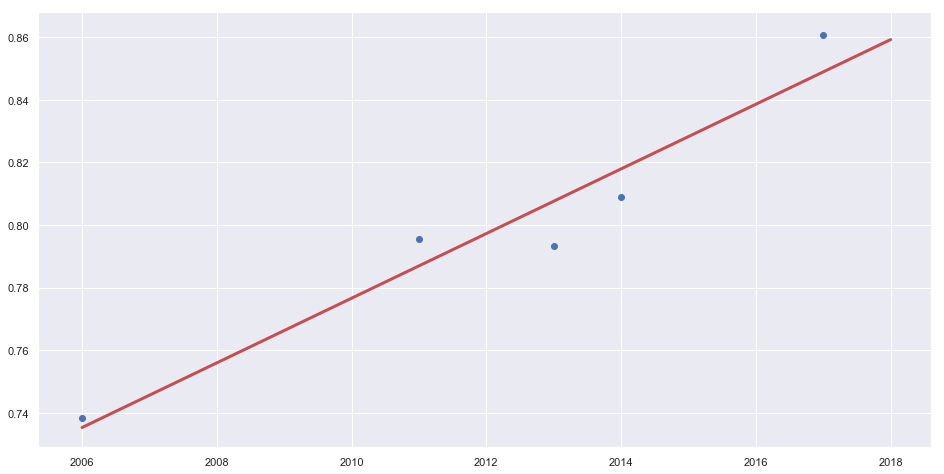

In [27]:
#Obtain data for the country
country_data = pd.DataFrame(data2_1[data2_1["country"].isin(['Jamaica'])])
year = pd.DataFrame(country_data['year'])
FC = pd.DataFrame(country_data['Freedom to make life choices'])
# Create a Linear Regression object
linreg = LinearRegression()
# Train the Linear Regression model
linreg.fit(year, FC)

# Visualisation for Togo 2018 regression. 
year2 = pd.DataFrame(year)
year2.loc[0] = 2018

# Formula for the Regression line
regline_x = year2
regline_y = linreg.intercept_ + linreg.coef_ * year2

# Plot the Linear Regression line
f, axes = plt.subplots(1, 1, figsize=(16, 8))
plt.plot(regline_x, regline_y, 'r-', linewidth = 3)
plt.scatter(year, FC)
plt.show()

Standard Deviation analysis for Freedom to make life choices

In [28]:
#Standard Deviation analysis for Freedom to make life choices

#Obtain the table of standard deviations
stddata_FC = {}
index = 0
for country_name in data2_1['country'].unique():
    country_data = data2_1[data2_1["country"].isin([country_name])]
    stddv = np.std(country_data['Freedom to make life choices'])
    stddata_FC[index] = [country_name, stddv]
    index += 1
stddata_FC = pd.DataFrame.from_dict(stddata_FC, orient='index', columns = ['country', 'Standard Deviation'])

#Plot out the distribution of Standard Deviation values
trace = go.Box(x = stddata_FC['Standard Deviation'], showlegend = False, name = '')
layout = go.Layout(title = 'Standard Deviation Distribution', width = 700, height = 300)
data = [trace]
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

Obtain countries with both a *Low Explained Variance* value and a *High Standard Deviation* for this variable

In [29]:
#Determine if there are countries with both low E.V. and higher-than-normal Standard Deviation

out_FC = stddata_FC[stddata_FC['Standard Deviation'] > 0.14] #countries with high S.D.
smallev_FC = evdata_FC[evdata_FC['Explained Variance'] < 0.5] #countries with low E.V.
lowev_out_FC = pd.merge(out_FC, smallev_FC, on='country')
lowev_out_FC[['country','Standard Deviation', 'Explained Variance']]

country  Standard Deviation  Explained Variance
0    Togo            0.150469            0.457143

Individual analysis for Togo

In [30]:
Togo = pd.DataFrame(data2_1[data2_1['country'].isin(['Togo'])])
data = [go.Scatter(x=Togo['year'], y=Togo['Freedom to make life choices'])]
layout = go.Layout(xaxis = dict(range = ['2006-01-01','2017-01-01']), width = 600, height = 350)
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

By observation, the data in year 2008 does not seem to follow the trend as shown in other years,  
so we can try to do linear regression (with year as X) without this data point.
If the *Explained Variance* is *low*, this country will be discarded.

In [31]:
#Obtain data for the country
country_data = pd.DataFrame(data2_1[data2_1["country"].isin(['Togo'])])
country_data.drop(int(country_data[country_data['year'] == 2008].index.values[0]), inplace = True)
year = pd.DataFrame(country_data['year'])
FC = pd.DataFrame(country_data['Freedom to make life choices'])
# Create a Linear Regression object
linreg = LinearRegression()
# Train the Linear Regression model
linreg.fit(year, FC)

#Adding the linear regression model into the table
added = False
if linreg.score(year, FC) >= 0.5:
  index = int(evdata_FC[evdata_FC['country'] == 'Togo'].index.values[0])
  evdata_FC.at[index, 'Explained Variance'] = linreg.score(year, FC)
  evdata_FC.at[index, 'linreg'] = linreg
  added = True
if added:
  print("Table updated! A new linear model has been assigned!")
else:
  data2_1.drop([int(i) for i in list(country_data.index.values)], inplace=True) #delete this country
  print("Table not updated due to low E.V. value")

Table updated! A new linear model has been assigned!


Visualisation of Togo's 2018 value from regression (For presentation slides purposes only)

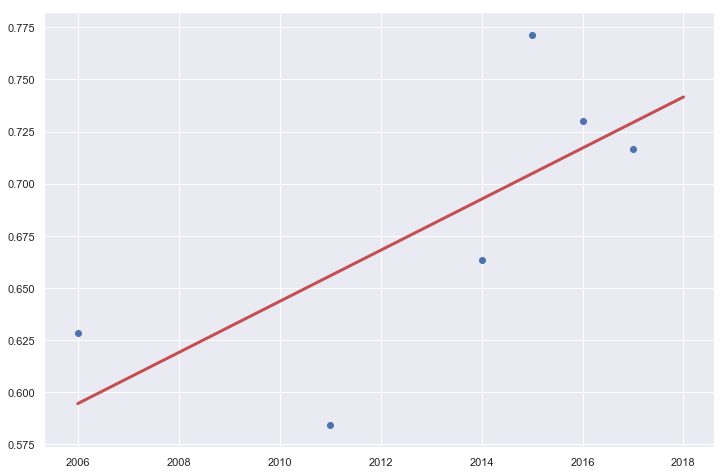

In [32]:
# Visualisation for Togo 2018 regression. 
year2 = pd.DataFrame(year)
year2.loc[0] = 2018

# Formula for the Regression line
regline_x = year2
regline_y = linreg.intercept_ + linreg.coef_ * year2

# Plot the Linear Regression line
f, axes = plt.subplots(1, 1, figsize=(12, 8))
plt.plot(regline_x, regline_y, 'r-', linewidth = 3)
plt.scatter(year, FC)
plt.show()

Standard Deviation analysis for Generosity

In [33]:
#Standard Deviation analysis for Generosity

#Obtain the table of standard deviations
stddata_G = {}
index = 0
for country_name in data2_1['country'].unique():
    country_data = data2_1[data2_1["country"].isin([country_name])]
    stddv = np.std(country_data['Generosity'])
    stddata_G[index] = [country_name, stddv]
    index += 1
stddata_G = pd.DataFrame.from_dict(stddata_G, orient='index', columns = ['country', 'Standard Deviation'])

#Plot out the distribution of Standard Deviation values
trace = go.Box(x = stddata_G['Standard Deviation'], showlegend = False, name = '')
layout = go.Layout(title = 'Standard Deviation Distribution', width = 700, height = 300)
data = [trace]
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

Obtain countries with both a *Low Explained Variance* value and a *High Standard Deviation* for this variable

In [34]:
#Determine if there are countries with both low E.V. and higher-than-normal Standard Deviation

out_G = stddata_G[stddata_G['Standard Deviation'] > 0.122] #countries with high S.D.
smallev_G = evdata_G[evdata_G['Explained Variance'] < 0.5] #countries with low E.V.
lowev_out_G = pd.merge(out_G, smallev_G, on='country')
lowev_out_G[['country','Standard Deviation', 'Explained Variance']]

country  Standard Deviation  Explained Variance
0  Kyrgyzstan            0.154869            0.494528

Individual analysis for Kyrgyzstan

In [35]:
#Plot values of Generosity of Kyrgyzstan over the years
Kyrgyzstan = pd.DataFrame(data2_1[data2_1['country'].isin(['Kyrgyzstan'])])
data = [go.Scatter(x=Kyrgyzstan['year'], y=Kyrgyzstan['Generosity'])]
layout = go.Layout(xaxis = dict(range = ['2006-01-01','2017-01-01']), width = 600, height = 350)
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

By observation, the data in year 2014 does not seem to follow the trend as shown in other years,  
so we can try to do linear regression (with year as X) without this data point.
If the *Explained Variance* is *low*, this country will be discarded.

In [36]:
#Obtain data for the country
country_data = pd.DataFrame(data2_1[data2_1["country"].isin(['Kyrgyzstan'])])
country_data.drop(int(country_data[country_data['year'] == 2014].index.values[0]), inplace = True)
year = pd.DataFrame(country_data['year'])
G = pd.DataFrame(country_data['Generosity'])
# Create a Linear Regression object
linreg = LinearRegression()
# Train the Linear Regression model
linreg.fit(year, G)

#Adding the linear regression model into the table
added = False
if linreg.score(year, G) >= 0.5:
  index = int(evdata_G[evdata_G['country'] == 'Kyrgyzstan'].index.values[0])
  evdata_G.at[index, 'Explained Variance'] = linreg.score(year, G)
  evdata_G.at[index, 'linreg'] = linreg
  added = True
if added:
  print("Table updated! A new linear model has been assigned!")
else:
  data2_1.drop([int(i) for i in list(country_data.index.values)], inplace=True) #delete this country
  print("Table not updated due to low E.V. value")

Table updated! A new linear model has been assigned!


Standard Deviation analysis for Perceptions of corruption

In [37]:
#Standard Deviation analysis for Perceptions of corruption

#Obtain the table of standard deviations
stddata_PC = {}
index = 0
for country_name in data2_1['country'].unique():
    country_data = data2_1[data2_1["country"].isin([country_name])]
    stddv = np.std(country_data['Perceptions of corruption'])
    stddata_PC[index] = [country_name, stddv]
    index += 1
stddata_PC = pd.DataFrame.from_dict(stddata_PC, orient='index', columns = ['country', 'Standard Deviation'])

#Plot out the distribution of Standard Deviation values
trace = go.Box(x = stddata_PC['Standard Deviation'], showlegend = False, name = '')
layout = go.Layout(title = 'Standard Deviation Distribution', width = 700, height = 300)
data = [trace]
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

Obtain countries with both a *Low Explained Variance* value and a *High Standard Deviation* for this variable

In [38]:
#Determine if there are countries with both low E.V. and higher-than-normal Standard Deviation

out_PC = stddata_PC[stddata_PC['Standard Deviation'] > 0.12] #countries with high S.D.
smallev_PC = evdata_PC[evdata_PC['Explained Variance'] < 0.5] #countries with low E.V.
lowev_out_PC = pd.merge(out_PC, smallev_PC, on='country')
lowev_out_PC[['country','Standard Deviation', 'Explained Variance']]

country  Standard Deviation  Explained Variance
0  Georgia            0.129263            0.135556
1   Kuwait            0.125917            0.436413

Individual analysis for Georgia

In [39]:
#Plot values of Perceptions of corruption of Georgia over the years
Georgia = pd.DataFrame(data2_1[data2_1['country'].isin(['Georgia'])])
data = [go.Scatter(x=Georgia['year'], y=Georgia['Perceptions of corruption'])]
layout = go.Layout(xaxis = dict(range = ['2006-01-01','2017-01-01']), width = 600, height = 350)
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

By observation, the trends in the data before and after year 2012 differ a lot,  
so we can try to do linear regression (with year as X) with year 2012 onwards only.
If the *Explained Variance* is *low*, this country will be discarded.

In [40]:
#Obtain data for the country
country_data = pd.DataFrame(data2_1[data2_1["country"].isin(['Georgia'])])
country_data.drop([int(i) for i in list(country_data[country_data['year'] < 2012].index.values)], inplace = True)
year = pd.DataFrame(country_data['year'])
PC = pd.DataFrame(country_data['Perceptions of corruption'])
# Create a Linear Regression object
linreg = LinearRegression()
# Train the Linear Regression model
linreg.fit(year, PC)

#Adding the linear regression model into the table
added = False
if linreg.score(year, PC) >= 0.5:
  index = int(evdata_PC[evdata_PC['country'] == 'Georgia'].index.values[0])
  evdata_PC.at[index, 'Explained Variance'] = linreg.score(year, PC)
  evdata_PC.at[index, 'linreg'] = linreg
  added = True
if added:
  print("Table updated! A new linear model has been assigned!")
else:
  data2_1.drop([int(i) for i in list(country_data.index.values)], inplace=True) #delete this country
  print("Table not updated due to low E.V. value")

Table updated! A new linear model has been assigned!


Individual analysis for Kuwait

In [41]:
#Plot values of Perceptions of corruption of Kuwait over the years
Kuwait = pd.DataFrame(data2_1[data2_1['country'].isin(['Kuwait'])])
data = [go.Scatter(x=Kuwait['year'], y=Kuwait['Perceptions of corruption'])]
layout = go.Layout(xaxis = dict(range = ['2006-01-01','2017-01-01']), width = 600, height = 350)
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

There are only 4 data points.  
We already cannot afford to remove any more data points now, otherwise the total data points are equal to or fewer than 3.  
Simply ignore and remove the country

In [42]:
country_data = data2_1[data2_1["country"].isin(['Kuwait'])]
data2_1.drop([int(i) for i in list(country_data.index.values)], inplace=True)

## Part 3: Using Suitable Models/Methods to Predict Values of the Variables
---
The prediction result will be stored in a Pandas data frame, named data2018

In [43]:
data2018 = {}

In [44]:
#Predict the values of Log GDP per capita

#Prediction with linear models
GDP_lin = pd.DataFrame(evdata_GDP[evdata_GDP['Explained Variance'] >= 0.5])

for country_name in GDP_lin['country']:
  if country_name in data2_1['country'].unique():
    country_data = GDP_lin[GDP_lin['country'] == country_name] #extract country data
    linreg = list(country_data['linreg'])[0] #extract linear model
    y = linreg.intercept_ + linreg.coef_ * 2018 #make prediction
    data2018[country_name] = [float(list(y[0])[0])] #store predicted value

#Prediction with mean
GDP_mean = pd.DataFrame(evdata_GDP[evdata_GDP['Explained Variance'] < 0.5])

for country_name in GDP_mean['country']:
  if country_name in data2_1['country'].unique():
    country_data = data2_1[data2_1["country"].isin([country_name])] #extract country data
    mean = np.mean(country_data['Log GDP per capita']) #calculate mean
    data2018[country_name] = [mean] #store predicted value

In [45]:
#Predict the values of Social support

#Prediction with linear models
SS_lin = pd.DataFrame(evdata_SS[evdata_SS['Explained Variance'] >= 0.5])

for country_name in SS_lin['country']:
  if country_name in data2_1['country'].unique():
    country_data = SS_lin[SS_lin['country'] == country_name] #extract country data
    linreg = list(country_data['linreg'])[0] #extract linear model
    y = linreg.intercept_ + linreg.coef_ * 2018 #make prediction
    dlist = data2018[country_name]
    dlist.append(float(list(y[0])[0]))
    data2018[country_name] = dlist #store predicted value

#Prediction with mean
SS_mean = pd.DataFrame(evdata_SS[evdata_SS['Explained Variance'] < 0.5])

for country_name in SS_mean['country']:
  if country_name in data2_1['country'].unique():
    country_data = data2_1[data2_1["country"].isin([country_name])] #extract country data
    mean = np.mean(country_data['Social support']) #calculate mean
    dlist = data2018[country_name]
    dlist.append(mean)
    data2018[country_name] = dlist #store predicted value

In [46]:
#Predict the values of Healthy life expectancy at birth

#Prediction with linear models
HLE_lin = pd.DataFrame(evdata_HLE[evdata_HLE['Explained Variance'] >= 0.5])

for country_name in HLE_lin['country']:
  if country_name in data2_1['country'].unique():
    country_data = HLE_lin[HLE_lin['country'] == country_name] #extract country data
    linreg = list(country_data['linreg'])[0] #extract linear model
    y = linreg.intercept_ + linreg.coef_ * 2018 #make prediction
    dlist = data2018[country_name]
    dlist.append(float(list(y[0])[0]))
    data2018[country_name] = dlist #store predicted value

#Prediction with mean
HLE_mean = pd.DataFrame(evdata_HLE[evdata_HLE['Explained Variance'] < 0.5])

for country_name in HLE_mean['country']:
  if country_name in data2_1['country'].unique():
    country_data = data2_1[data2_1["country"].isin([country_name])] #extract country data
    mean = np.mean(country_data['Healthy life expectancy at birth']) #calculate mean
    dlist = data2018[country_name]
    dlist.append(mean)
    data2018[country_name] = dlist #store predicted value

In [47]:
#Predict the values of Freedom to make life choices

#Prediction with linear models
FC_lin = pd.DataFrame(evdata_FC[evdata_FC['Explained Variance'] >= 0.5])

for country_name in FC_lin['country']:
  if country_name in data2_1['country'].unique():
    country_data = FC_lin[FC_lin['country'] == country_name] #extract country data
    linreg = list(country_data['linreg'])[0] #extract linear model
    y = linreg.intercept_ + linreg.coef_ * 2018 #make prediction
    dlist = data2018[country_name]
    dlist.append(float(list(y[0])[0]))
    data2018[country_name] = dlist #store predicted value

#Prediction with mean
FC_mean = pd.DataFrame(evdata_FC[evdata_FC['Explained Variance'] < 0.5])

for country_name in FC_mean['country']:
  if country_name in data2_1['country'].unique():
    country_data = data2_1[data2_1["country"].isin([country_name])] #extract country data
    mean = np.mean(country_data['Freedom to make life choices']) #calculate mean
    dlist = data2018[country_name]
    dlist.append(mean)
    data2018[country_name] = dlist #store predicted value

In [48]:
#Predict the values of Generosity

#Prediction with linear models
G_lin = pd.DataFrame(evdata_G[evdata_G['Explained Variance'] >= 0.5])

for country_name in G_lin['country']:
  if country_name in data2_1['country'].unique():
    country_data = G_lin[G_lin['country'] == country_name] #extract country data
    linreg = list(country_data['linreg'])[0] #extract linear model
    y = linreg.intercept_ + linreg.coef_ * 2018 #make prediction
    dlist = data2018[country_name]
    dlist.append(float(list(y[0])[0]))
    data2018[country_name] = dlist #store predicted value

#Prediction with mean
G_mean = pd.DataFrame(evdata_G[evdata_G['Explained Variance'] < 0.5])

for country_name in G_mean['country']:
  if country_name in data2_1['country'].unique():
    country_data = data2_1[data2_1["country"].isin([country_name])] #extract country data
    mean = np.mean(country_data['Generosity']) #calculate mean
    dlist = data2018[country_name]
    dlist.append(mean)
    data2018[country_name] = dlist #store predicted value

In [49]:
#Predict the values of Perceptions of corruption

#Prediction with linear models
PC_lin = pd.DataFrame(evdata_PC[evdata_PC['Explained Variance'] >= 0.5])

for country_name in PC_lin['country']:
  if country_name in data2_1['country'].unique():
    country_data = PC_lin[PC_lin['country'] == country_name] #extract country data
    linreg = list(country_data['linreg'])[0] #extract linear model
    y = linreg.intercept_ + linreg.coef_ * 2018 #make prediction
    dlist = data2018[country_name]
    dlist.append(float(list(y[0])[0]))
    data2018[country_name] = dlist #store predicted value

#Prediction with mean
PC_mean = pd.DataFrame(evdata_PC[evdata_PC['Explained Variance'] < 0.5])

for country_name in PC_mean['country']:
  if country_name in data2_1['country'].unique():
    country_data = data2_1[data2_1["country"].isin([country_name])] #extract country data
    mean = np.mean(country_data['Perceptions of corruption']) #calculate mean
    dlist = data2018[country_name]
    dlist.append(mean)
    data2018[country_name] = dlist #store predicted value

In [50]:
#Put the result in a pandas data frame
data2018_temp = {}
index = 0
for country_name in data2018:
  dlist = data2018[country_name]
  dlist.insert(0, country_name)
  data2018_temp[index] = dlist
  index += 1
c = ['country', 'Log GDP per capita', 'Social support', 'Healthy life expectancy at birth', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']
data2018 = pd.DataFrame.from_dict(data2018_temp, orient='index', columns = c)

data2018.head()

country  Log GDP per capita  Social support  \
0  Afghanistan            7.556672        0.517146   
1      Albania            9.395344        0.598737   
2      Algeria            9.557861        0.804633   
3       Angola            8.825380        0.737973   
4      Armenia            9.063797        0.705386   

   Healthy life expectancy at birth  Freedom to make life choices  Generosity  \
0                         52.727593                      0.388715   -0.020793   
1                         69.437901                      0.779566   -0.105019   
2                         65.908829                      0.421771   -0.186511   
3                         54.600483                      0.085282   -0.427748   
4                         65.306449                      0.520092   -0.154848   

   Perceptions of corruption  
0                   0.826794  
1                   0.859691  
2                   0.718727  
3                   0.690105  
4                   0.882539

## Part 4: Obtaining the Model for Happiness Score Prediction
---
We are aware that there is an available methodology that we can use to directly calculate the happiness score using the six variables,  
but since the coefficients used in the equation are changing every year (and are obtained through an unknown statistical method), and  
the method for calculating values of the residuals are not revealed, we instead use Multi-Variate Linear Regression to predict the scores.
>Response Variable: **Happiness Score**  
>Predictor Feature: **All six variables**  
> Regression Model : **Happiness Score** = $a_1$ $\times$ **Log GDP per Capita** + $a_2$ $\times$ **Social Support** + $a_3$ $\times$ **Healthy Life Expectancy at Birth** + $a_4$ $\times$ **Freedom to Make Life Choices** + $a_5$ $\times$ **Generosity** + $a_6$ $\times$ **Perceptions of Corruption** + $b$  


### Importing the Dataset
The dataset for the happiness score is imported into a Pandas data frame  
The variable data_score holds the data frame

In [51]:
#obtain the data for happiness score in 2018 report, based on 2017 data
data_score = pd.read_excel('WHR2018Chapter2OnlineData.xls', sheet_name = 'Figure2.2', usecols = range(0,2))
data_score = data_score.rename(columns={'Country': 'country'})
data_score.head()

country  Happiness score
0      Finland           7.6321
1       Norway           7.5937
2      Denmark           7.5553
3      Iceland           7.4952
4  Switzerland           7.4873

### Re-importing the Dataset
The dataset for the six variables need to be re-imported into a Pandas data frame, because some data points were deleted previously  
The variable data2_1 holds the data frame

In [52]:
#re-obtain the data of individual variables in year 2017
data2_1 = pd.read_excel('WHR2018Chapter2OnlineData.xls', sheet_name = 'Table2.1', usecols = range(0,9))
data2_1.drop(['Life Ladder'], axis=1, inplace=True)
data2_1.head()

country  year  Log GDP per capita  Social support  \
0  Afghanistan  2008            7.168690        0.450662   
1  Afghanistan  2009            7.333790        0.552308   
2  Afghanistan  2010            7.386629        0.539075   
3  Afghanistan  2011            7.415019        0.521104   
4  Afghanistan  2012            7.517126        0.520637   

   Healthy life expectancy at birth  Freedom to make life choices  Generosity  \
0                         49.209663                      0.718114    0.181819   
1                         49.624432                      0.678896    0.203614   
2                         50.008961                      0.600127    0.137630   
3                         50.367298                      0.495901    0.175329   
4                         50.709263                      0.530935    0.247159   

   Perceptions of corruption  
0                   0.881686  
1                   0.850035  
2                   0.706766  
3                   0.731109  
4                   0.775620

### Merging the Datasets  
The latest data for the six variables and the happiness score of 2018 report are merged together to form a single Pandas data frame  
The data frame is stored in the variable data_var_score

In [53]:
#use the latest variable data for linear regression
data = pd.DataFrame(data2_1[data2_1['year'] == 2017])
country_no2017 = []
for c in list(data2_1['country'].unique()):
    if c not in list(data['country']):
        country_no2017.append(str(c))
for c in country_no2017:
    d = data2_1[data2_1['country'] == c]
    d = d[d['year'] == max(d['year'])]
    data = data.append({'country' : c, 'year': list(d['year'])[0], 'Log GDP per capita' : list(d['Log GDP per capita'])[0], \
                       'Social support' : list(d['Social support'])[0], 'Healthy life expectancy at birth' : list(d['Healthy life expectancy at birth'])[0], \
                       'Freedom to make life choices' : list(d['Freedom to make life choices'])[0], 'Generosity' : list(d['Generosity'])[0], \
                       'Perceptions of corruption' : list(d['Perceptions of corruption'])[0]}, ignore_index = True)
data2_1 = data
data2_1 = data2_1.sort_values(by=['country'])

data_var_score = pd.merge(data_score, data2_1, on = ['country'])
data_var_score.drop(['year'], axis=1, inplace=True)
data_var_score.head()

country  Happiness score  Log GDP per capita  Social support  \
0      Finland           7.6321           10.612338        0.963826   
1       Norway           7.5937           11.081789        0.950128   
2      Denmark           7.5553           10.748989        0.952100   
3      Iceland           7.4952           10.760409        0.966753   
4  Switzerland           7.4873           10.955548        0.949661   

   Healthy life expectancy at birth  Freedom to make life choices  Generosity  \
0                         71.696960                      0.962199   -0.012174   
1                         71.086586                      0.953017    0.210104   
2                         71.662498                      0.955416    0.145387   
3                         72.755981                      0.938783    0.235479   
4                         73.173759                      0.924997    0.167875   

   Perceptions of corruption  
0                   0.192413  
1                   0.249711  
2                   0.181148  
3                   0.726845  
4                   0.316183

Check data summary

In [54]:
data_var_score.describe()

Happiness score  Log GDP per capita  Social support  \
count       153.000000          144.000000      151.000000   
mean          5.367191            9.296237        0.800880   
std           1.127956            1.194936        0.123976   
min           2.904500            6.625341        0.319589   
25%           4.447000            8.490350        0.725425   
50%           5.352500            9.491220        0.822771   
75%           6.166800           10.248196        0.903926   
max           7.632100           11.693157        0.966753   

       Healthy life expectancy at birth  Freedom to make life choices  \
count                        153.000000                    151.000000   
mean                          62.880401                      0.769069   
std                            7.683262                      0.140990   
min                           44.386528                      0.374542   
25%                           57.462997                      0.694284   
50%                           64.347450                      0.810402   
75%                           68.581551                      0.881517   
max                           75.812401                      0.985178   

       Generosity  Perceptions of corruption  
count  142.000000                 140.000000  
mean    -0.010517                   0.730029  
std      0.160729                   0.181910  
min     -0.296735                   0.158601  
25%     -0.138134                   0.679160  
50%     -0.036485                   0.779276  
75%      0.094242                   0.851269  
max      0.628706                   0.954393

Get rid of empty values

In [55]:
data_nonull = data_var_score.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

Split dataset into train and test, and train the linear regression model

In [56]:
varPredictor = pd.DataFrame(data_nonull[['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']])
countryScore = pd.DataFrame(data_nonull['Happiness score'])

In [57]:
# Import LinearRegression model from Scikit-Learn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Split the dataset into Train and Test       
varPredictor_train, varPredictor_test, countryScore_train, countryScore_test = train_test_split(varPredictor, countryScore, test_size = 30)

# Create a Linear Regression object
linreg = LinearRegression()

# Train the Linear Regression model
linreg.fit(varPredictor_train, countryScore_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Check coefficients and intercept

In [58]:
print('Intercept \t: b =', linreg.intercept_[0])
print('Coefficients \t:')
for i in range(0,6):
  print('a{} ='.format(i+1), linreg.coef_[0][i])

Intercept 	: b = -2.207864895205634
Coefficients 	:
a1 = 0.18084805699362547
a2 = 2.6614195288672566
a3 = 0.047453337383209455
a4 = 1.7870271067671966
a5 = -0.05232635653366258
a6 = -0.8034445885403722


Visualize predicted scores vs. true scores for both train and test data

Check *Explained Variance* for both train and test

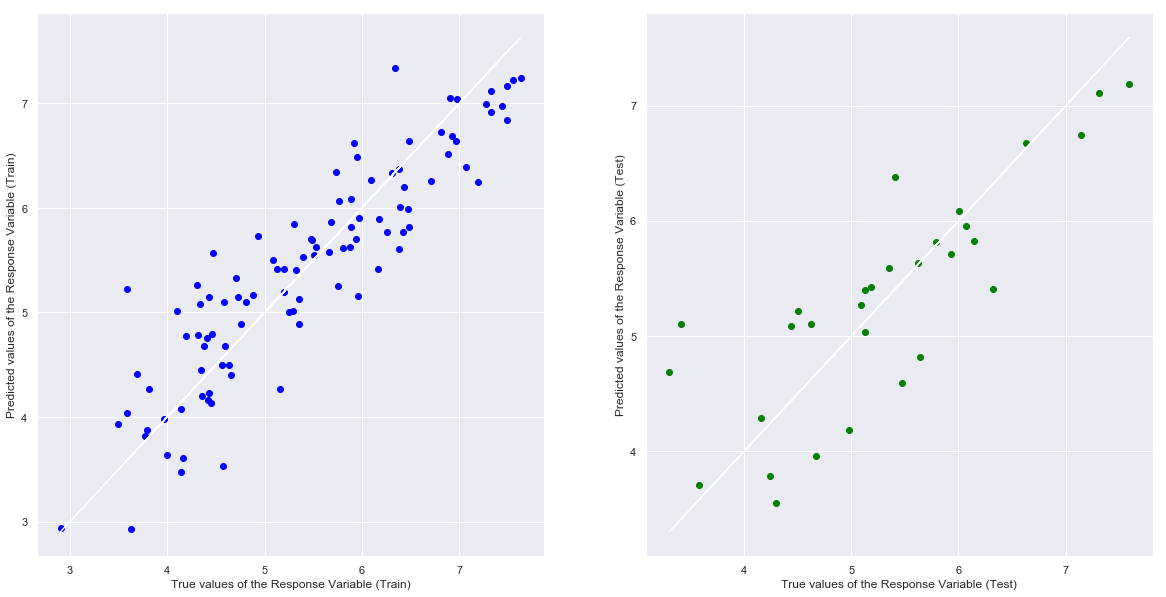

In [59]:
countryScore_train_pred = linreg.predict(varPredictor_train)
countryScore_test_pred = linreg.predict(varPredictor_test)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].scatter(countryScore_train, countryScore_train_pred, color = "blue")
axes[0].plot(countryScore_train, countryScore_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(countryScore_test, countryScore_test_pred, color = "green")
axes[1].plot(countryScore_test, countryScore_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

In [60]:
print("Explained Variance (R^2) on Train Set \t:", linreg.score(varPredictor_train, countryScore_train))
print("Explained Variance (R^2) on Test Set \t:", linreg.score(varPredictor_test, countryScore_test))

Explained Variance (R^2) on Train Set 	: 0.8152389313565945
Explained Variance (R^2) on Test Set 	: 0.6554619566269846


## Part 5: Prediction of Happiness Score Using Obtained Linear Regression Model
---
We fit the data of the predicted values of the variables into the linear regression model to predict the happiness score that should be in 2019 report.

Check data summary

In [61]:
data2018.describe()

Log GDP per capita  Social support  Healthy life expectancy at birth  \
count          142.000000      142.000000                        142.000000   
mean             9.239353        0.799965                         63.600189   
std              1.190588        0.128570                          7.489629   
min              6.465542        0.266618                         45.228058   
25%              8.406105        0.735010                         57.968420   
50%              9.469007        0.822195                         64.948081   
75%             10.184955        0.900396                         68.995123   
max             11.470908        0.975919                         76.668220   

       Freedom to make life choices  Generosity  Perceptions of corruption  
count                    142.000000  142.000000                 142.000000  
mean                       0.744798    0.002529                   0.740813  
std                        0.161817    0.163886                   0.187519  
min                        0.073269   -0.427748                   0.016797  
25%                        0.645771   -0.120730                   0.703026  
50%                        0.771949   -0.012488                   0.797209  
75%                        0.858294    0.087585                   0.859456  
max                        1.028536    0.654473                   0.956011

Predict 2019 score

In [62]:
varPredictor2018 = pd.DataFrame(data2018[['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']])
countryScore2019 = linreg.predict(varPredictor2018)

In [63]:
label = ['Happiness Score 2019']
happiness2019 = pd.DataFrame.from_records(countryScore2019, columns=label)
happiness2019.head()

Happiness Score 2019
0              3.068636
1              5.087703
2              4.975733
3              3.563542
4              4.636091

Generate a combined data frame of the six variables + predicted happiness score

In [64]:
total2019 = data2018.merge(happiness2019, how='outer', left_index=True, right_index=True)
total2019.head()

country  Log GDP per capita  Social support  \
0  Afghanistan            7.556672        0.517146   
1      Albania            9.395344        0.598737   
2      Algeria            9.557861        0.804633   
3       Angola            8.825380        0.737973   
4      Armenia            9.063797        0.705386   

   Healthy life expectancy at birth  Freedom to make life choices  Generosity  \
0                         52.727593                      0.388715   -0.020793   
1                         69.437901                      0.779566   -0.105019   
2                         65.908829                      0.421771   -0.186511   
3                         54.600483                      0.085282   -0.427748   
4                         65.306449                      0.520092   -0.154848   

   Perceptions of corruption  Happiness Score 2019  
0                   0.826794              3.068636  
1                   0.859691              5.087703  
2                   0.718727              4.975733  
3                   0.690105              3.563542  
4                   0.882539              4.636091

## Part 6: Simple Visualization of Predicted Outcome

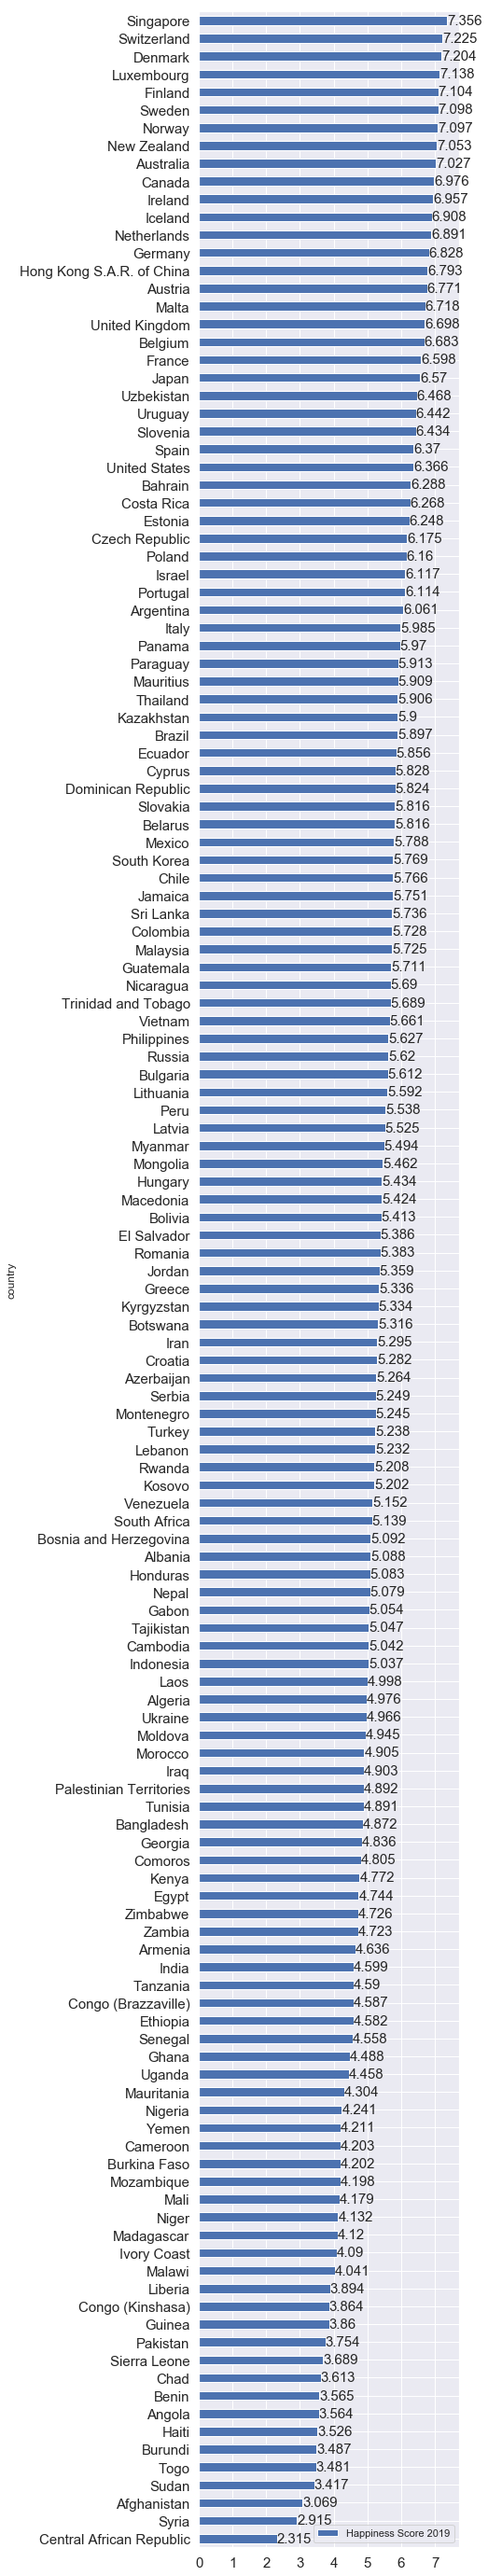

In [65]:
# Visualise 2019 happiness score by country in descending order
score2019 = total2019.iloc[:,[0, 7]]
score2019.head()
score2019_sorted = score2019.sort_values('Happiness Score 2019', ascending = True)
score2019_sorted.plot.barh(x = 'country', figsize=(5,50), fontsize = 15)
for y, x in enumerate(score2019_sorted.iloc[:,1]):
    plt.annotate(str(round(x, 3)), xy=(x, y), va='center', fontsize = 15)
          

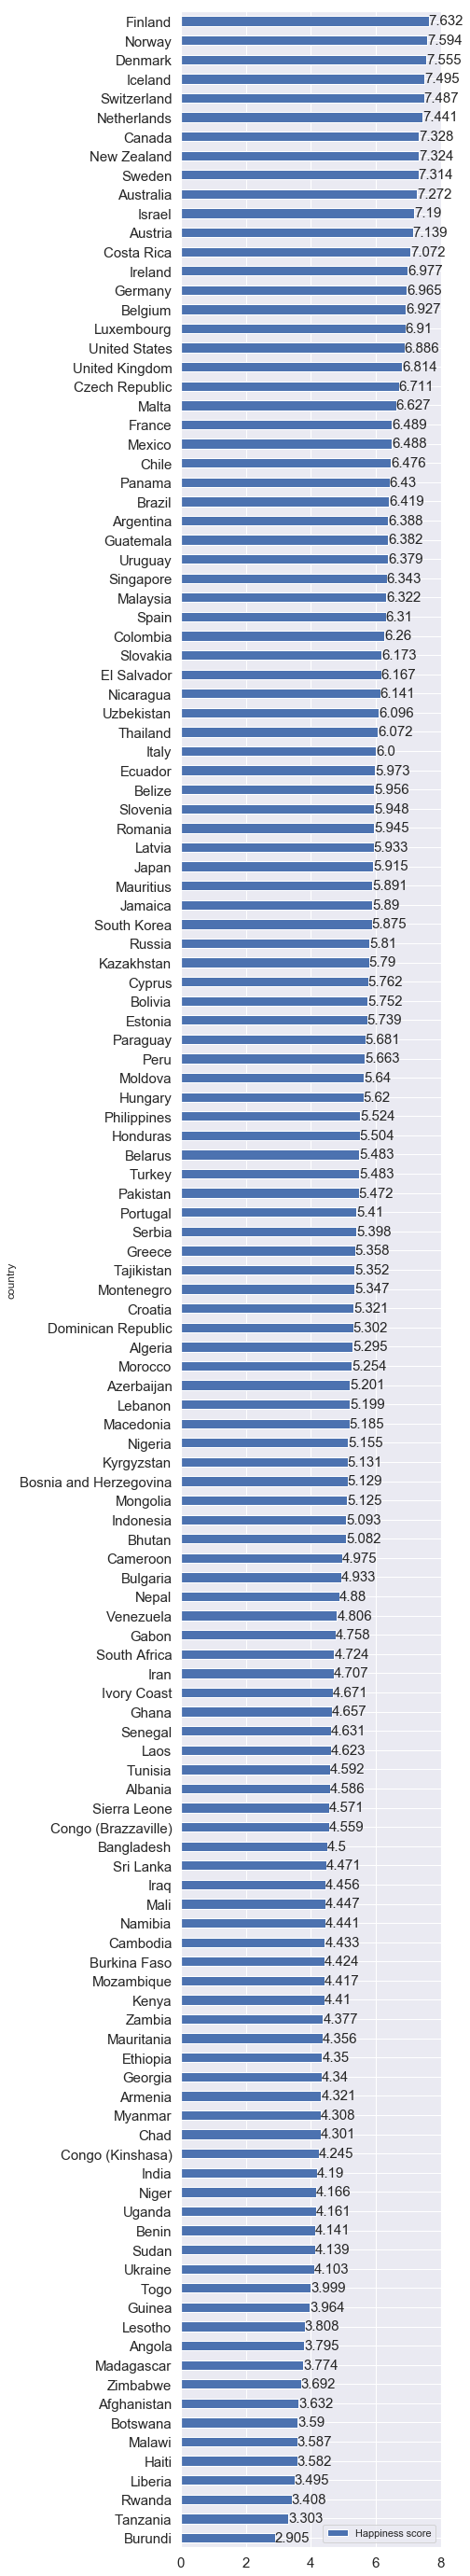

In [66]:
# Visualise 2018 happiness score by country in descending order for brief comparison
data_nonull.head()
score2018 = pd.DataFrame(data_nonull[['country', 'Happiness score']])
score2018_sorted = score2018.sort_values('Happiness score', ascending = True)
score2018_sorted.plot.barh(x = 'country', figsize=(5,50), fontsize = 15)
for y, x in enumerate(score2018_sorted.iloc[:,1]):
    plt.annotate(str(round(x, 3)), xy=(x, y), va='center', fontsize = 15)

### Visualize the 2019 score on the world map
---
The predicted happiness scores for all countries in 2019  report is presented on the world map.  
>The predicted happiness scores are represented by a color scale, with darker color representing higher score.  
>Grey color is applied to countries without a happiness score in the predicted report.

In [67]:
#An Overview of World Happiness Score
score = pd.DataFrame(total2019[['country', 'Happiness Score 2019']]) #obtain happiness score
world = pd.read_csv('world.csv') #import abbreviations of countries
world = world.rename(columns={'Country': 'country'})
score = pd.merge(score, world, on='country') #merge the two datasets

#plot the choropleth graph for predicted happiness score for 2019 report
trc = dict (type = 'choropleth', locations = score['Code'], colorscale = 'Blues', reversescale=True, z = score['Happiness Score 2019'], text = score['country'])
lyt = go.Layout(
    title = go.layout.Title(
        text = 'Predicted 2019 Happiness Score'
    ),
    geo = go.layout.Geo(
        landcolor = 'grey',
        showland = True,
        showcountries = True,
        showframe = False,
        showcoastlines = False,
        projection = go.layout.geo.Projection(
            type = 'equirectangular'
        )
    )
)
map = go.Figure(data = [trc], layout = lyt)
py.iplot(map)

### Visualize the change of score on the world map
---
The predicted happiness score changes for all countries in 2019  report is presented on the world map.  
>The predicted happiness scores are represented by a color scale, with blue representing increase and red representing decrease.  
>Grey color is applied to countries without a happiness score in the predicted report.

In [68]:
score2018 = pd.read_excel('WHR2018Chapter2OnlineData.xls', sheet_name = 'Figure2.2', usecols = range(0,2))
score2019 = pd.DataFrame(total2019[['country','Happiness Score 2019']])
index = 0
change = {}
for country_name in list(score2019['country'].unique()):
  country_name = str(country_name)
  country_data_2018 = score2018[score2018['Country'] == country_name]
  country_data_2019 = score2019[score2019['country'] == country_name]
  score_18 = country_data_2018['Happiness score']
  if len(list(score_18))==0:
    continue
  score_18 = float(list(score_18)[0])
  score_19 = country_data_2019['Happiness Score 2019']
  score_19 = float(list(score_19)[0])
  score_change = score_19 - score_18
  change[index] = [country_name, score_change]
  index += 1
change = pd.DataFrame.from_dict(change, orient='index', columns = ['country', 'Score Change'])


#An Overview of World Happiness Score
world = pd.read_csv('world.csv') #import abbreviations of countries
world = world.rename(columns={'Country': 'country'})
score = pd.merge(change, world, on='country') #merge the two datasets

#plot the choropleth graph for predicted happiness score for 2019 report
trc = dict (type = 'choropleth', locations = score['Code'], colorscale =[[0, "red"],[0.5, "rgb(255, 255, 255)"],[1, "blue"]], z = score['Score Change'], text = score['country'])
lyt = go.Layout(
    title = go.layout.Title(
        text = 'Happiness Score Change'
    ),
    geo = go.layout.Geo(
        landcolor = 'grey',
        showland = True,
        showcountries = True,
        showframe = False,
        showcoastlines = False,
        projection = go.layout.geo.Projection(
            type = 'equirectangular'
        )
    )
)
map = go.Figure(data = [trc], layout = lyt)
py.iplot(map)

It's interesting to see that the world is mostly becoming less happy than the previous year. 

## Part 7: Attempt to Find out the Reason for the Change in Happiness Score by Region

In [69]:
regions = pd.read_excel('WHR2018Chapter2OnlineData.xls', sheet_name = 'SupportingFactors', usecols = range(0,2))
regions.head()

country              Region indicator
0  Afghanistan                    South Asia
1      Albania    Central and Eastern Europe
2      Algeria  Middle East and North Africa
3       Angola            Sub-Saharan Africa
4    Argentina   Latin America and Caribbean

In [70]:
data_prev_year = pd.merge(data_nonull, regions, on = 'country')
data_new_year = pd.merge(total2019, regions, on = 'country')
data_prev_year.head()

country  Happiness score  Log GDP per capita  Social support  \
0      Finland           7.6321           10.612338        0.963826   
1       Norway           7.5937           11.081789        0.950128   
2      Denmark           7.5553           10.748989        0.952100   
3      Iceland           7.4952           10.760409        0.966753   
4  Switzerland           7.4873           10.955548        0.949661   

   Healthy life expectancy at birth  Freedom to make life choices  Generosity  \
0                         71.696960                      0.962199   -0.012174   
1                         71.086586                      0.953017    0.210104   
2                         71.662498                      0.955416    0.145387   
3                         72.755981                      0.938783    0.235479   
4                         73.173759                      0.924997    0.167875   

   Perceptions of corruption Region indicator  
0                   0.192413   Western Europe  
1                   0.249711   Western Europe  
2                   0.181148   Western Europe  
3                   0.726845   Western Europe  
4                   0.316183   Western Europe

In [71]:
data_prevbyregion = data_prev_year.sort_values('Region indicator', ascending = True)
data_prevregiongroup = data_prevbyregion.groupby('Region indicator')
prev_mean = data_prevregiongroup.mean()
prev_mean.head(10)

Happiness score  Log GDP per capita  \
Region indicator                                                          
Central and Eastern Europe                 5.569257            9.931727   
Commonwealth of Independent States         5.206073            9.099834   
East Asia                                  5.638167           10.125484   
Latin America and Caribbean                5.938538            9.250375   
Middle East and North Africa               5.271788            9.655354   
North America and ANZ                      7.202600           10.689613   
South Asia                                 4.603900            8.434936   
Southeast Asia                             5.339725            9.367371   
Sub-Saharan Africa                         4.230178            7.916435   
Western Europe                             6.810435           10.680971   

                                    Social support  \
Region indicator                                     
Central and Eastern Europe                0.853664   
Commonwealth of Independent States        0.814769   
East Asia                                 0.871047   
Latin America and Caribbean               0.856925   
Middle East and North Africa              0.768020   
North America and ANZ                     0.937568   
South Asia                                0.712456   
Southeast Asia                            0.813308   
Sub-Saharan Africa                        0.703297   
Western Europe                            0.915138   

                                    Healthy life expectancy at birth  \
Region indicator                                                       
Central and Eastern Europe                                 67.628022   
Commonwealth of Independent States                         63.840442   
East Asia                                                  70.557199   
Latin America and Caribbean                                64.840551   
Middle East and North Africa                               66.306589   
North America and ANZ                                      71.609093   
South Asia                                                 59.847963   
Southeast Asia                                             62.783010   
Sub-Saharan Africa                                         52.989573   
Western Europe                                             72.315232   

                                    Freedom to make life choices  Generosity  \
Region indicator                                                               
Central and Eastern Europe                              0.736360   -0.094487   
Commonwealth of Independent States                      0.735546   -0.048256   
East Asia                                               0.687379   -0.037830   
Latin America and Caribbean                             0.823168   -0.089057   
Middle East and North Africa                            0.638038   -0.087076   
North America and ANZ                                   0.908438    0.241331   
South Asia                                              0.774866    0.057618   
Southeast Asia                                          0.881892    0.205426   
Sub-Saharan Africa                                      0.718662   -0.023263   
Western Europe                                          0.854937    0.077130   

                                    Perceptions of corruption  
Region indicator                                               
Central and Eastern Europe                           0.854230  
Commonwealth of Independent States                   0.754398  
East Asia                                            0.791614  
Latin America and Caribbean                          0.788479  
Middle East and North Africa                         0.781930  
North America and ANZ                                0.424879  
South Asia                                           0.761783  
Southeast Asia                                       0.690818  
Sub-Saharan Africa  

In [72]:
data_newbyregion = data_new_year.sort_values('Region indicator', ascending = True)
data_newregiongroup = data_newbyregion.groupby('Region indicator')
new_mean = data_newregiongroup.mean()
cols = new_mean.columns.tolist()
cols = cols[-1:] + cols[:-1]
new_mean = new_mean[cols]
new_mean.rename(columns={'Happiness Score 2019':'Happiness score'}, inplace=True)
new_mean.head(10)

Happiness score  Log GDP per capita  \
Region indicator                                                          
Central and Eastern Europe                 5.585787            9.907854   
Commonwealth of Independent States         5.348267            9.164376   
East Asia                                  6.148344           10.374735   
Latin America and Caribbean                5.640566            9.352033   
Middle East and North Africa               4.997364            9.390425   
North America and ANZ                      6.855597           10.691086   
South Asia                                 4.518111            8.397422   
Southeast Asia                             5.649714            9.342563   
Sub-Saharan Africa                         4.244788            7.881621   
Western Europe                             6.677560           10.652216   

                                    Social support  \
Region indicator                                     
Central and Eastern Europe                0.839233   
Commonwealth of Independent States        0.817672   
East Asia                                 0.864000   
Latin America and Caribbean               0.851560   
Middle East and North Africa              0.728117   
North America and ANZ                     0.933684   
South Asia                                0.646302   
Southeast Asia                            0.808992   
Sub-Saharan Africa                        0.703019   
Western Europe                            0.920087   

                                    Healthy life expectancy at birth  \
Region indicator                                                       
Central and Eastern Europe                                 67.782770   
Commonwealth of Independent States                         64.314598   
East Asia                                                  72.409676   
Latin America and Caribbean                                65.212076   
Middle East and North Africa                               64.495379   
North America and ANZ                                      71.886597   
South Asia                                                 60.064736   
Southeast Asia                                             63.505166   
Sub-Saharan Africa                                         53.777583   
Western Europe                                             72.615591   

                                    Freedom to make life choices  Generosity  \
Region indicator                                                               
Central and Eastern Europe                              0.699250   -0.101947   
Commonwealth of Independent States                      0.715681   -0.043042   
East Asia                                               0.731810    0.037953   
Latin America and Caribbean                             0.801271   -0.043002   
Middle East and North Africa                            0.630984   -0.065628   
North America and ANZ                                   0.905310    0.253355   
South Asia                                              0.709726    0.064665   
Southeast Asia                                          0.885801    0.211993   
Sub-Saharan Africa                                      0.686460   -0.021925   
Western Europe                                          0.850922    0.085468   

                                    Perceptions of corruption  
Region indicator                                               
Central and Eastern Europe                           0.875165  
Commonwealth of Independent States                   0.759892  
East Asia                                            0.698699  
Latin America and Caribbean                          0.793954  
Middle East and North Africa                         0.774636  
North America and ANZ                                0.461440  
South Asia                                           0.781574  
Southeast Asia                                       0.710020  
Sub-Saharan Africa  

In [73]:
# Plot change of happiness score and weighted change of individual variables from 2017 to 2018

# coefficients from multi-variate linear regression
a1 = 0.22058652954121996
a2 = 3.427833357989398
a3 = 0.04018636252849772
a4 = 1.577325081074943
a5 = 0.05862022602896193
a6 = -0.4577211674939384

coefficients = [a6, a5, a4, a3, a2, a1]

Previous happiness score: 5.206072720614347
Predicted happiness score: 5.348267069478316
Increase in happiness score: 0.14219434886396964


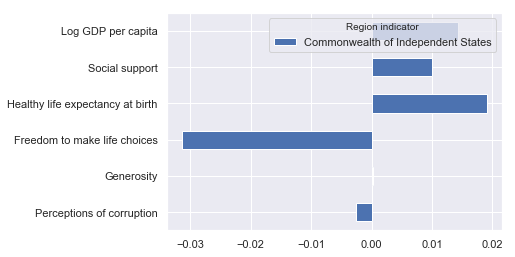

In [74]:
# Commonwealth of Independent States
IndepStates = pd.concat([prev_mean.iloc[[1]], new_mean.iloc[[1]]])
IndepStates_change = IndepStates.diff().iloc[[1]]
IndepStates_transpose = IndepStates_change.transpose()
IndepStates_rev_row = IndepStates_transpose.iloc[::-1]
for i in range(0,6):
  IndepStates_rev_row.iloc[i] *= coefficients[i]
IndepStates_rev_row.iloc[:-1].plot.barh()
print("Previous happiness score:", IndepStates.iloc[0][0])
print("Predicted happiness score:", IndepStates.iloc[1][0])
print("Increase in happiness score:", IndepStates.iloc[1][0] - IndepStates.iloc[0][0])

From the chart, we can infer that the increase in happiness score in the Independent States is likely due to the increase in healthy life expectancy at birth as well as Log GDP per capita within the region

Previous happiness score: 5.638166586558024
Predicted happiness score: 6.1483442843462
Increase in happiness score: 0.5101776977881753


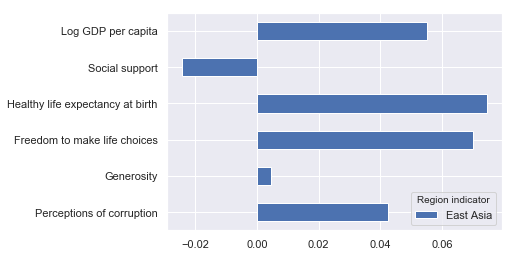

In [75]:
# East Asia
EastAsia = pd.concat([prev_mean.iloc[[2]], new_mean.iloc[[2]]])
EastAsia_change = EastAsia.diff().iloc[[1]]
EastAsia_transpose = EastAsia_change.transpose()
EastAsia_rev_row = EastAsia_transpose.iloc[::-1]
for i in range(0,6):
  EastAsia_rev_row.iloc[i] *= coefficients[i]
EastAsia_rev_row.iloc[:-1].plot.barh()
print("Previous happiness score:", EastAsia.iloc[0][0])
print("Predicted happiness score:", EastAsia.iloc[1][0])
print("Increase in happiness score:", EastAsia.iloc[1][0] - EastAsia.iloc[0][0])

From the chart, we can infer that the increase in happiness score East Asia is likely due to the increase in healthy life expectancy at birth and freedom to make life choices within the region.

Previous happiness score: 5.938538085846674
Predicted happiness score: 5.640565980738943
Increase in happiness score: -0.2979721051077311


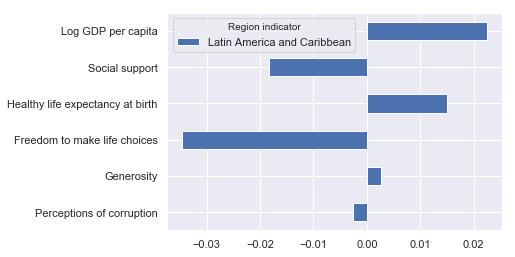

In [76]:
# Latin America and Caribbean
LAC = pd.concat([prev_mean.iloc[[3]], new_mean.iloc[[3]]])
LAC_change = LAC.diff().iloc[[1]]
LAC_transpose = LAC_change.transpose()
LAC_rev_row = LAC_transpose.iloc[::-1]
for i in range(0,6):
  LAC_rev_row.iloc[i] *= coefficients[i]
LAC_rev_row.iloc[:-1].plot.barh()
print("Previous happiness score:", LAC.iloc[0][0])
print("Predicted happiness score:", LAC.iloc[1][0])
print("Increase in happiness score:", LAC.iloc[1][0] - LAC.iloc[0][0])

From the chart, we can infer that the decrease in happiness score in Latin America and Carribean is likely due to the decrease in freedom to make life choices within the region.

Previous happiness score: 5.271787524223328
Predicted happiness score: 4.997363789492444
Increase in happiness score: -0.2744237347308838


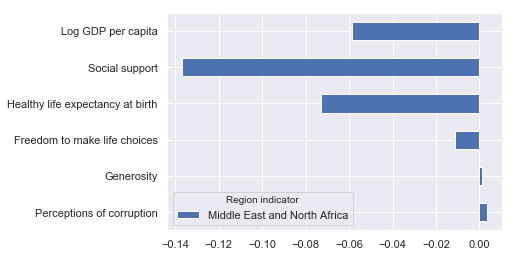

In [77]:
# Middle East and North Africa
MidEastNorthAfrica = pd.concat([prev_mean.iloc[[4]], new_mean.iloc[[4]]])
MidEastNorthAfrica_change = MidEastNorthAfrica.diff().iloc[[1]]
MidEastNorthAfrica_transpose = MidEastNorthAfrica_change.transpose()
MidEastNorthAfrica_rev_row = MidEastNorthAfrica_transpose.iloc[::-1]
for i in range(0,6):
  MidEastNorthAfrica_rev_row.iloc[i] *= coefficients[i]
MidEastNorthAfrica_rev_row.iloc[:-1].plot.barh()
print("Previous happiness score:", MidEastNorthAfrica.iloc[0][0])
print("Predicted happiness score:", MidEastNorthAfrica.iloc[1][0])
print("Increase in happiness score:", MidEastNorthAfrica.iloc[1][0] - MidEastNorthAfrica.iloc[0][0])

From the chart, we can infer that the decrease in happiness score in the Middle East and North Africa is likely due to the fall in social support within the region.

Previous happiness score: 7.202600002288818
Predicted happiness score: 6.855596932092524
Increase in happiness score: -0.34700307019629406


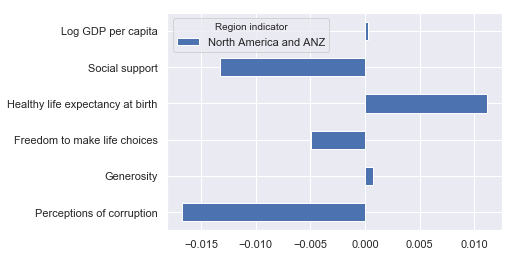

In [78]:
# North America and ANZ
NA_ANZ = pd.concat([prev_mean.iloc[[5]], new_mean.iloc[[5]]])
NA_ANZ_change = NA_ANZ.diff().iloc[[1]]
NA_ANZ_transpose = NA_ANZ_change.transpose()
NA_ANZ_rev_row = NA_ANZ_transpose.iloc[::-1]
for i in range(0,6):
  NA_ANZ_rev_row.iloc[i] *= coefficients[i]
NA_ANZ_rev_row.iloc[:-1].plot.barh()
print("Previous happiness score:", NA_ANZ.iloc[0][0])
print("Predicted happiness score:", NA_ANZ.iloc[1][0])
print("Increase in happiness score:", NA_ANZ.iloc[1][0] - NA_ANZ.iloc[0][0])

From the chart, we can infer that the decrease in happiness score in North America and ANZ is likely due to the increase in perception of corruption within the region (coefficient a6 is a negative value, hence the negative weighted value)

Previous happiness score: 4.6038999898093085
Predicted happiness score: 4.518110956350057
Increase in happiness score: -0.08578903345925148


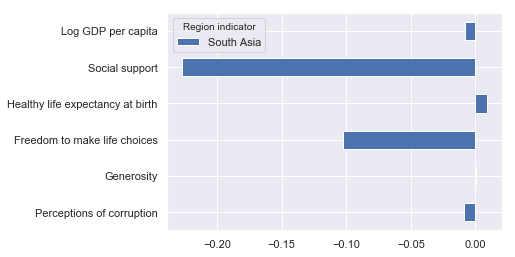

In [79]:
# South Asia
SouthAsia = pd.concat([prev_mean.iloc[[6]], new_mean.iloc[[6]]])
SouthAsia_change = SouthAsia.diff().iloc[[1]]
SouthAsia_transpose = SouthAsia_change.transpose()
SouthAsia_rev_row = SouthAsia_transpose.iloc[::-1]
for i in range(0,6):
  SouthAsia_rev_row.iloc[i] *= coefficients[i]
SouthAsia_rev_row.iloc[:-1].plot.barh()
print("Previous happiness score:", SouthAsia.iloc[0][0])
print("Predicted happiness score:", SouthAsia.iloc[1][0])
print("Increase in happiness score:", SouthAsia.iloc[1][0] - SouthAsia.iloc[0][0])

From the chart, we can infer that the decrease in happiness score in South Asia is likely due to the fall in social support within the region.

Previous happiness score: 5.339724957942963
Predicted happiness score: 5.649714262314395
Increase in happiness score: 0.3099893043714328


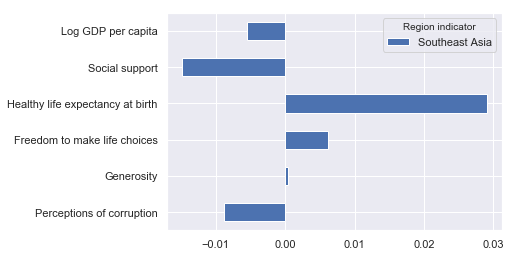

In [80]:
# Southeast Asia
SEA = pd.concat([prev_mean.iloc[[7]], new_mean.iloc[[7]]])
SEA_change = SEA.diff().iloc[[1]]
SEA_transpose = SEA_change.transpose()
SEA_rev_row = SEA_transpose.iloc[::-1]
SEA_rev_row.head(8)
for i in range(0,6):
  SEA_rev_row.iloc[i] *= coefficients[i]
SEA_rev_row.iloc[:-1].plot.barh()
print("Previous happiness score:", SEA.iloc[0][0])
print("Predicted happiness score:", SEA.iloc[1][0])
print("Increase in happiness score:", SEA.iloc[1][0] - SEA.iloc[0][0])

From the chart, we can infer that the increase in happiness score in Southeast Asia is due to the increase in healthy life expectancy at birth within the region.

Previous happiness score: 4.230177779992421
Predicted happiness score: 4.244788456298763
Increase in happiness score: 0.01461067630634183


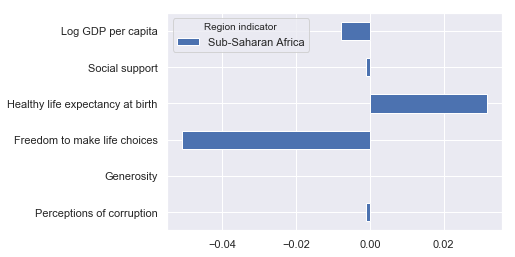

In [81]:
# Sub-Saharan Africa
SSAfrica = pd.concat([prev_mean.iloc[[8]], new_mean.iloc[[8]]])
SSAfrica_change = SSAfrica.diff().iloc[[1]]
SSAfrica_transpose = SSAfrica_change.transpose()
SSAfrica_rev_row = SSAfrica_transpose.iloc[::-1]
for i in range(0,6):
  SSAfrica_rev_row.iloc[i] *= coefficients[i]
SSAfrica_rev_row.iloc[:-1].plot.barh()
print("Previous happiness score:", SSAfrica.iloc[0][0])
print("Predicted happiness score:", SSAfrica.iloc[1][0])
print("Increase in happiness score:", SSAfrica.iloc[1][0] - SSAfrica.iloc[0][0])

From the chart, the increase in happiness score in Sub-Saharan Africa is likely due to the increase in healthy life expectancy at birth in the region.

Previous happiness score: 6.8104349851608275
Predicted happiness score: 6.677560237926161
Increase in happiness score: -0.1328747472346663


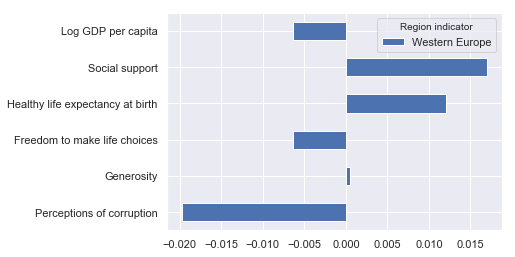

In [82]:
# Western Europe
WesternEurope = pd.concat([prev_mean.iloc[[9]], new_mean.iloc[[9]]])
WesternEurope_change = WesternEurope.diff().iloc[[1]]
WesternEurope_transpose = WesternEurope_change.transpose()
WesternEurope_rev_row = WesternEurope_transpose.iloc[::-1]
for i in range(0,6):
  WesternEurope_rev_row.iloc[i] *= coefficients[i]
WesternEurope_rev_row.iloc[:-1].plot.barh()
print("Previous happiness score:", WesternEurope.iloc[0][0])
print("Predicted happiness score:", WesternEurope.iloc[1][0])
print("Increase in happiness score:", WesternEurope.iloc[1][0] - WesternEurope.iloc[0][0])

From the chart, the decrease in happiness score in Western Europe is likely due to the rise in perceptions of corruption within the region.

Previous happiness score: 5.5692571231297086
Predicted happiness score: 5.585786757121831
Change in happiness score: 0.01652963399212215


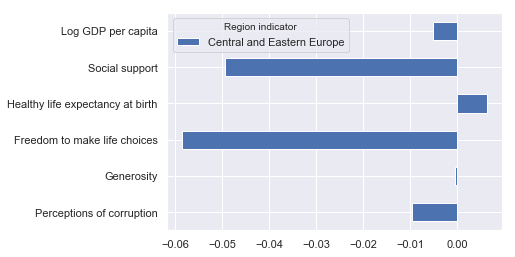

In [83]:
# Central and Eastern Europe
CEEurope = pd.concat([prev_mean.iloc[[0]], new_mean.iloc[[0]]])
CEEurope_change = CEEurope.diff().iloc[[1]]
CEEurope_transpose = CEEurope_change.transpose()
CEEurope_transpose.head()
CEEurope_rev_row = CEEurope_transpose.iloc[::-1]
for i in range(0,6):
  CEEurope_rev_row.iloc[i] *= coefficients[i]
CEEurope_rev_row.iloc[:-1].plot.barh()
print("Previous happiness score:", CEEurope.iloc[0][0])
print("Predicted happiness score:", CEEurope.iloc[1][0])
print("Change in happiness score:", CEEurope.iloc[1][0] - CEEurope.iloc[0][0])

From the chart, we can infer that the increase in happiness score in Central and Eastern Europe is likely due to the increase in healthy life expectancy at birth within the region.

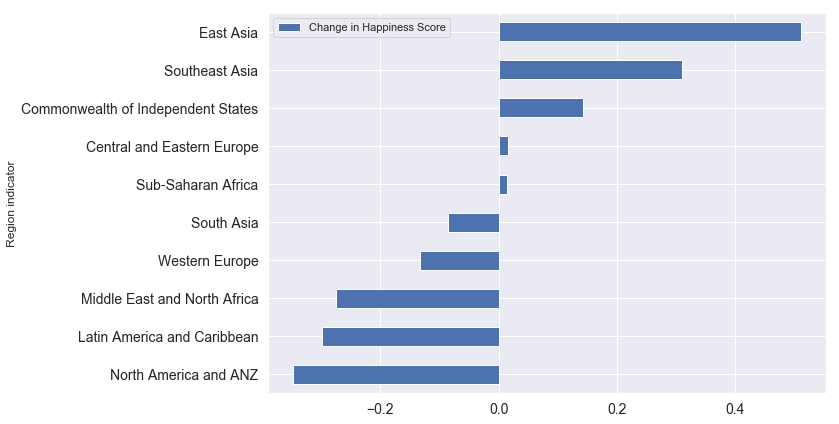

In [84]:
# Overview of changes in happiness score by region
region_prev = pd.DataFrame(prev_mean[['Happiness score']])
region_prev.rename(columns={'Happiness score':'Happiness score 2018'}, inplace=True)
region_prev_new = pd.merge(region_prev, new_mean[['Happiness score']], on = 'Region indicator')
region_prev_new.rename(columns={'Happiness score':'Happiness score 2019'}, inplace=True)
region_prev_new['Change in Happiness Score'] = region_prev_new['Happiness score 2019'] - region_prev_new['Happiness score 2018']
region_prev_new_sorted = region_prev_new.sort_values('Change in Happiness Score', ascending = True)
region_prev_new_sorted[['Change in Happiness Score']].plot.barh(figsize=(10,7), fontsize = 14)

In [85]:
region_prev_new_sorted

Happiness score 2018  \
Region indicator                                           
North America and ANZ                           7.202600   
Latin America and Caribbean                     5.938538   
Middle East and North Africa                    5.271788   
Western Europe                                  6.810435   
South Asia                                      4.603900   
Sub-Saharan Africa                              4.230178   
Central and Eastern Europe                      5.569257   
Commonwealth of Independent States              5.206073   
Southeast Asia                                  5.339725   
East Asia                                       5.638167   

                                    Happiness score 2019  \
Region indicator                                           
North America and ANZ                           6.855597   
Latin America and Caribbean                     5.640566   
Middle East and North Africa                    4.997364   
Western Europe                                  6.677560   
South Asia                                      4.518111   
Sub-Saharan Africa                              4.244788   
Central and Eastern Europe                      5.585787   
Commonwealth of Independent States              5.348267   
Southeast Asia                                  5.649714   
East Asia                                       6.148344   

                                    Change in Happiness Score  
Region indicator                                               
North America and ANZ                               -0.347003  
Latin America and Caribbean                         -0.297972  
Middle East and North Africa                        -0.274424  
Western Europe                                      -0.132875  
South Asia                                          -0.085789  
Sub-Saharan Africa                                   0.014611  
Central and Eastern Europe                           0.016530  
Commonwealth of Independent States                   0.142194  
Southeast Asia                                       0.309989  
East Asia                                            0.510178